## Introduction {.unnumbered}

In the CrimeGraph project, I will explore training a graph deep learning  model to forecast the probability of crime events in the City of Baltimore, using data provided by [SpotCrime](https://spotcrime.com/#what-is-spotcrime). SpotCrime maintains a uniquely comprehensive database of geo-coded crime reports obtained from public safety databases and news reports from across the country. They were kind enough to grant me access to 23 years of data documenting crime events in the Baltimore.

I plan to adopt the GLDNet^[Gated Localised Diffusion] architecture described in the 2020 paper _[Graph Deep Learning Model for Network-based Predictive Hotspot Mapping of Sparse Spatio-Temporal Events](https://discovery.ucl.ac.uk/id/eprint/10085742/)_. Models with this design can learn from the spatial patterns of crime events by representing intersecting city streets as a graph of nodes and edges.

In this WIP^[Work-in-Progress] notebook, we'll use geographic data to prepare the street graph, as part of a process known as 'feature engineering'. In a future notebook, we will perform feature engineering of the SpotCrime data itself.

The code is available on [GitHub](https://github.com/subelsky/crimegraph).

## AI Safety Caveat {.unnumbered}

::: {.callout-caution}
Machine learning techniques frequently cause harm in law enforcement contexts due to societal biases baked into the tools and data we use to train models. I am committed to ensuring that this experiment demonstrates positive ways to improve public safety.
:::

Here are the steps I have taken so far:

* Focusing on a subgraph of streets running west-to-east across Baltimore's core, to ensure we train the model on events in a variety of neighborhoods (important because of the extreme levels of racial segregation in the city).

* Restricting the goal to forecasting only violent crimes (thus excluding property crimes). If deep learning technology can be used to reliably prevent people from becoming victims of violent crime, it may be worth the risk. This assumption would need to be tested in dialogue with affected communities before fielding it as a forecasting tool.

* Using language that focuses on prevention, and not police response. The system should make forecasts that could be used to cue community crime prevention resources (such as violence interrupters).

Please [let me know](mailto:contact@subelsky.com) if you have suggestions of other risk mitigation measures.

## Loading Street Segment Geometry

We begin by loading a GIS^[Geographic Information System] shapefile describing the geometry of Baltimore streets. The shapefile was downloaded from [Maryland's Open Data portal](https://data-maryland.opendata.arcgis.com/datasets/maryland::baltimore-city-roads/explore?location=39.297904%2C-76.586923%2C13.00).

In [2]:
# Load geopandas, an open source code library that processes shapefile data
import geopandas as gpd

# Read the shapefile into memory. gdf stands for 'geodataframe'
streets_gdf = gpd.read_file('../../data/city_streets/MDOT_Know_Your_Roads.shp')

The geodataframe coordinates are specified in spherical coordinates^[Known as the WGS84 coordinate reference system]
(hours/minutes/seconds), which are incovenient for measuring distances between intersecting streets. Since Baltimore is a relatively small area, we can ignore the curvature of the Earth, enabling us to measure straight-line^[Euclidean] distances in meters.

In [3]:
# Convert the geodataframe to use the Maryland State Plane coordinate system,
# delineated in meters

streets_gdf = streets_gdf.to_crs(epsg=26985)

In [4]:
# Remove unused columns from the shapefile, and rename remaining columns
# so they are easier to read
streets_gdf.drop(columns=['MUNICIPALI', 'OWNERSHIP', 'SHAPE_Leng'], inplace=True)
streets_gdf.rename(columns={'OBJECTID': 'NodeID', 'ROAD_NAME': 'Name'}, inplace=True)

streets_gdf.head()

,NodeID,Name,geometry
0,367091,HAMPNETT AV,"LINESTRING Z (437097.924 186262.548 0.000, 437..."
1,367095,RASPE AV,"LINESTRING Z (439591.312 187041.316 0.000, 439..."
2,367101,CARBORE WY,"LINESTRING Z (439647.748 179306.321 0.000, 439..."
3,367108,LAKEHURST DR (NB/L),"LINESTRING Z (431231.983 189327.930 0.000, 431..."
4,367122,BANK ST,"LINESTRING Z (440417.241 180192.691 0.000, 440..."


Note the `geometry` column: it contains 3D `LineString` segments, each made up of a series of points with 3 coordinates.  The collection of `LineStrings` describes the path of each street segment. One street is often represented by multiple segments.

## Restrict the Data to Streets Within City Limits

Since we are only interested in forecasting events within city limits, we should exclude streets that are maintained by the city, but which lie outside of those limits.

In [5]:
# 1. filter_gdf() is a custom function defined in the lib/ directory of this project
from lib.geo_utils import filter_gdf

# 2. Define city limits using spherical coordinates (degrees of latitude and longitude)
minLat, minLon = 39.19067660786725, -76.71297312947553
maxLat, maxLon = 39.37320150131267, -76.510739017176

# 3. Use the custom function to exclude streets (the function converts spherical
#    coordinates to the Maryland State Plane coordinate system automatically)

streets_gdf = filter_gdf(streets_gdf, minLat=minLat, minLon=minLon, maxLat=maxLat, maxLon=maxLon)
streets_gdf.head()

,NodeID,Name,geometry
0,367091,HAMPNETT AV,"LINESTRING Z (437097.924 186262.548 0.000, 437..."
1,367095,RASPE AV,"LINESTRING Z (439591.312 187041.316 0.000, 439..."
2,367101,CARBORE WY,"LINESTRING Z (439647.748 179306.321 0.000, 439..."
3,367108,LAKEHURST DR (NB/L),"LINESTRING Z (431231.983 189327.930 0.000, 431..."
4,367122,BANK ST,"LINESTRING Z (440417.241 180192.691 0.000, 440..."


## Plot Filtered Street Segments

This gives us a sanity check to make sure we selected the correct streets.

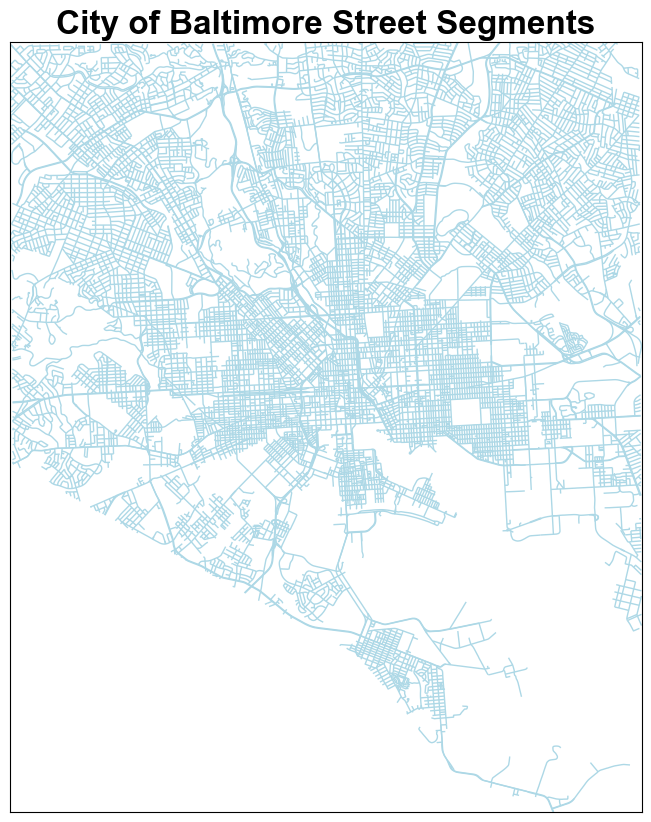

In [6]:
#| code-fold: true
from tkinter import font
from turtle import width
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

streets_gdf.plot(ax=ax, color='lightblue', linewidth=1)

min_x, min_y, max_x, max_y = streets_gdf.total_bounds

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

plt.title('City of Baltimore Street Segments', fontsize=24, fontweight='bold', fontname='Arial')

# Remove numbers on the axes
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Create a Sample of Streets

Since we will be constructing a graph that represents street intersections, I decided to zoom into a selection a handful of streets in the northern half of the city, to make sure the code for calculating the weights of the edges works correctly.

In [7]:
import re
from lib.geo_utils import filter_gdf

# match all streets that contain the following substrings
regex_pattern = r'(?:BALTIMORE ST|CALVERT ST|SOUTH ST)'
street_sample = streets_gdf[streets_gdf['Name'].str.contains(regex_pattern, na=False, regex=True)]

# We again use the filter_gdf custom function to exclude the far south extensions
# of Calvert St, which prevents the plot from getting too large
maxLat=39.374446325282264
minLon=-76.6587439176065

minLat=39.283440114622316
maxLon=-76.59163244865216

street_sample = filter_gdf(street_sample, minLat=minLat, minLon=minLon, maxLat=maxLat, maxLon=maxLon)

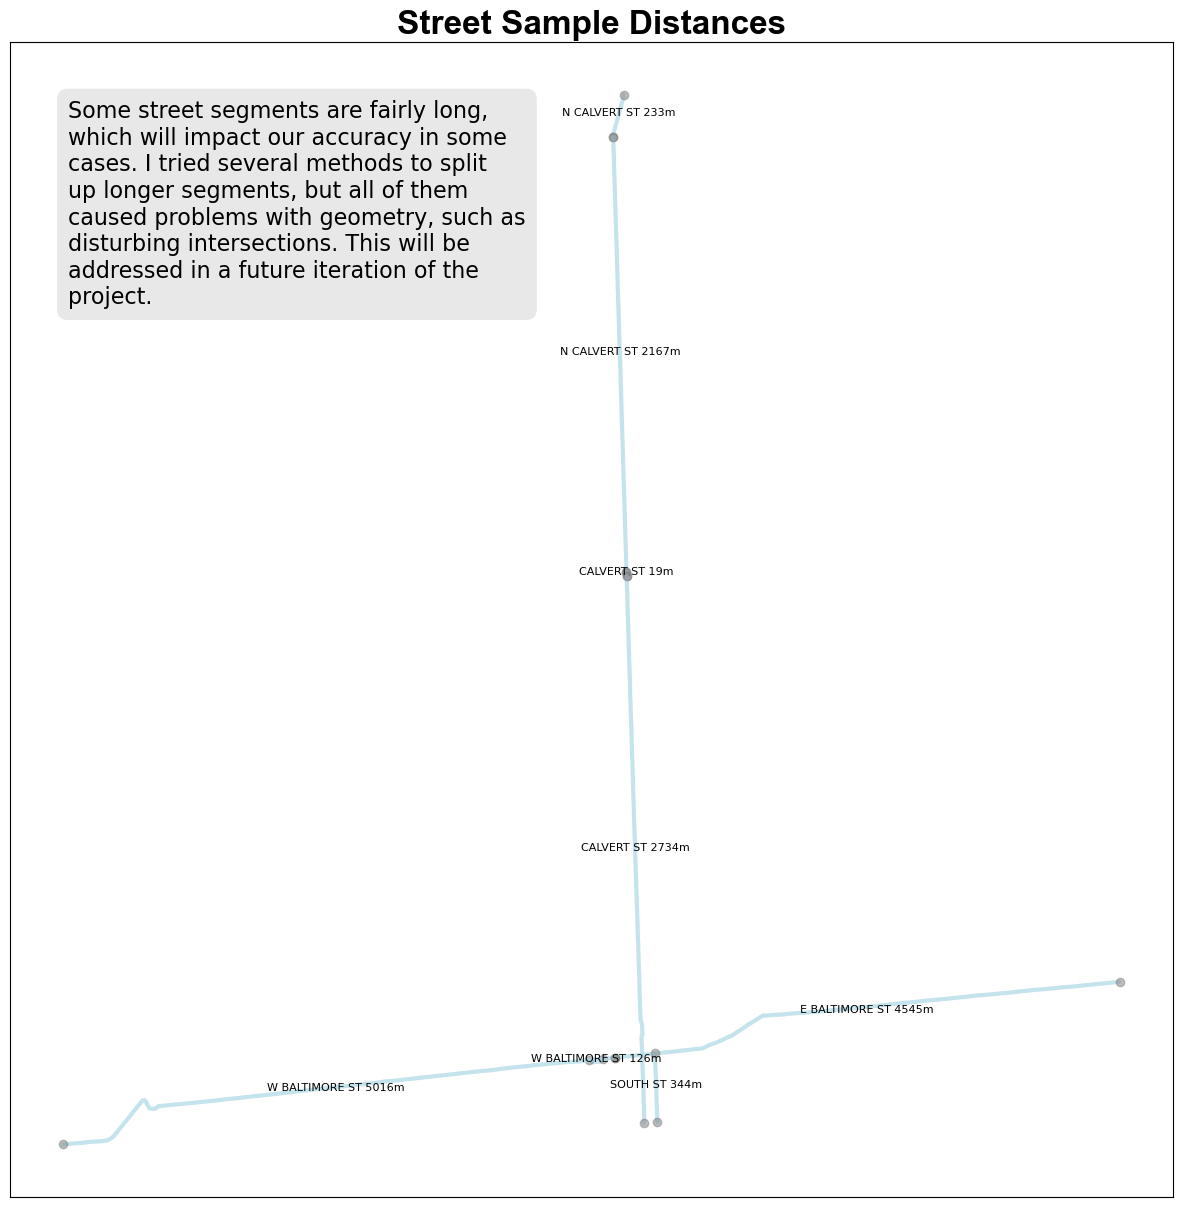

In [8]:
#| code-fold: true
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString, LineString, Point
import textwrap

fig, ax = plt.subplots(figsize=(15, 15))

# Walk through each street segment in street_sample and plot it on the map
for index, row in street_sample.iterrows():
    geom = row.geometry
    name = row['Name']

    if isinstance(geom, LineString):
        line_strings = [geom]
    elif isinstance(geom, MultiLineString):
        line_strings = geom

    for line in line_strings:
        x, y = line.xy
        ax.plot(x, y, color='lightblue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

        ax.plot(x[0], y[0], 'o', color='gray', alpha=0.5)    # Segment start point
        ax.plot(x[-1], y[-1], 'o', color='gray', alpha=0.5)  # Segment end point

        centroid = line.centroid
        name = f'{name} {row["geometry"].length:.0f}m'
        ax.text(centroid.x, centroid.y, name, fontsize=8, ha='center')

ax.set_title('Street Sample Distances', fontsize=24, fontweight='bold', fontname='Arial')

note = '''Some street segments are fairly long, which will impact our accuracy in some cases.
I tried several methods to split up longer segments, but all of them caused problems with geometry,
such as disturbing intersections. This will be addressed in a future iteration of the project.
'''

# remove newlines and extra spaces from note
note = re.sub(r'\s+', ' ', note).strip()
wrapped_text = textwrap.fill(note, width=40)

ax.text(0.05, 0.95, wrapped_text, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', wrap=True, 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='none', alpha=0.5))

ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Create a Sample Street Graph

The GLDNet architecture views the city as a graph representing street segments as nodes connected with edges. Each edge represents an intersection between street segment nodes, and each edge is described by a weight^[Using an exponentially-decaying Gaussian kernel function to e­valuate the similarity betwe­en two points, as described in the GLDnet paper] indicating how closely connected the streets are.

In the code below, `alpha` is a [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) that affects the model training process. It controls the rate of decay of the edge weights as the network distance^[The distance between the center of each street, if you walked along each street] between two intersecting street segments increases.

A higher value of `alpha` will result in a slower decay rate, meaning that for higher values, the weights will decrease more slowly as the distance between two intersection streets increases. I chose `750` as a starting point through trial and error, but we will need to do hyperparameter tuning experiments to find the most optimal value^[In the original GLDNet paper, the authors used a value of 5. `alpha` is likely sensitive to the geometry of the city being modeled.]. See the [GitHub](https://github.com/subelsky/crimegraph/blob/main/notebooks/street_graph_feature_engineering/lib/graphs.py) repository to see how `create_networkx_graph()` works.

In [9]:
# create_network_graph() is a custom function defined in the lib/ directory
from lib.graphs import create_network_graph
import re
import warnings

# there is a slight inconsistency for one intersection that we can safely ignore
warnings.filterwarnings('ignore') # there is a slight inconsistency for one intersection that we can safely ignore

# The variable G will contain the network graph of nodes and edges
G = create_network_graph(street_sample, alpha=750)

Here we print some basic facts about the graph, and show a sample of what the data looks like so far:

In [10]:
#| code-fold: true
print(G)

first_few_nodes = G.nodes.data()

for node in first_few_nodes:
    print(node)

Graph with 8 nodes and 7 edges
(71, {'NodeID': 368270, 'name': 'N CALVERT ST', 'position': (433234.76449570275, 184903.13711894283)})
(460, {'NodeID': 375575, 'name': 'W BALTIMORE ST', 'position': (433035.4508496049, 180198.99369446136)})
(1094, {'NodeID': 387189, 'name': 'E BALTIMORE ST', 'position': (435451.27511434647, 180441.2195487497)})
(1175, {'NodeID': 388713, 'name': 'W BALTIMORE ST', 'position': (430707.4139727321, 180056.19193840865)})
(3314, {'NodeID': 428785, 'name': 'SOUTH ST', 'position': (433572.47103290143, 180068.17071845438)})
(4740, {'NodeID': 450305, 'name': 'N CALVERT ST', 'position': (433248.1671875986, 183714.82279332186)})
(4886, {'NodeID': 453672, 'name': 'CALVERT ST', 'position': (433307.6642518902, 182623.34583798377)})
(4920, {'NodeID': 454701, 'name': 'CALVERT ST', 'position': (433385.9678910779, 181250.26493673338)})


## Plot Street Sample Network Graph

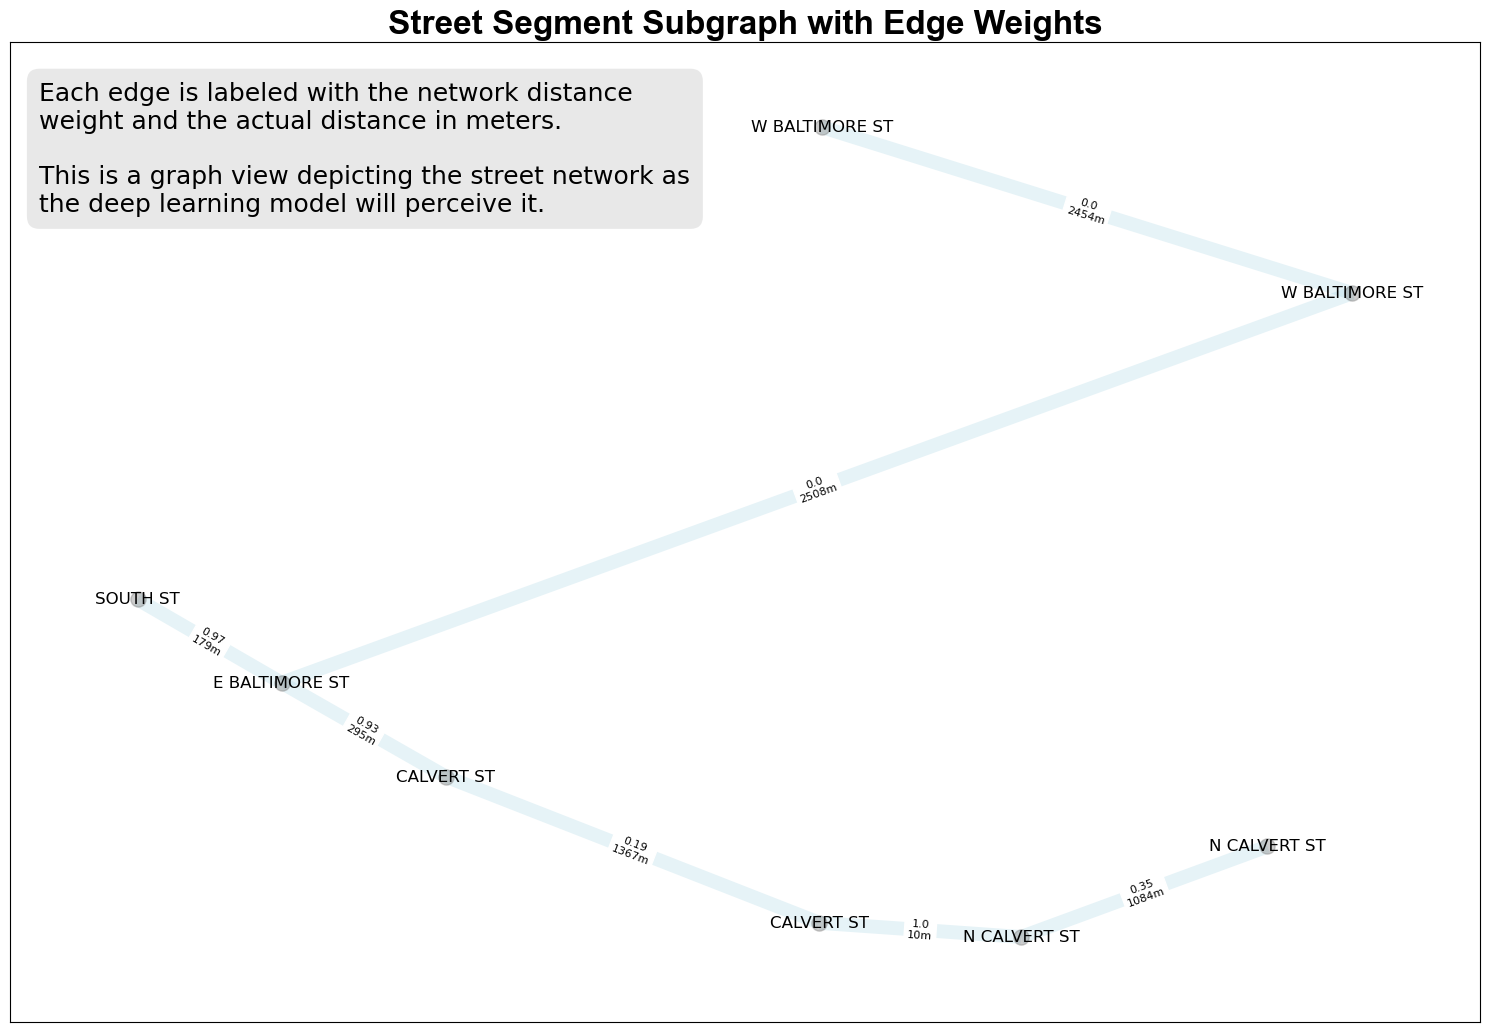

In [11]:
#| code-fold: true
# custom drawing function defined in the lib/ directory
from lib.plots import plot_nodes_and_edges
from matplotlib import pyplot as plt

plt.close()

fig, ax = plt.subplots(figsize=(15,10))

plt.title("Street Segment Subgraph with Edge Weights", fontsize=24, fontweight='bold', fontname='Arial')

note = '''Each edge is labeled with the network distance weight and
the actual distance in meters.'''

note = re.sub(r'\s+', ' ', note).strip()
wrapped_text = textwrap.fill(note, width=50)

wrapped_text = wrapped_text + '\n\nThis is a graph view depicting the street network as\n' \
        'the deep learning model will perceive it.'

ax.text(0.02, 0.96, wrapped_text, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', wrap=True, 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', edgecolor='none', alpha=0.5))

plot_nodes_and_edges(G, plt, fig, ax, 100)

plt.show()

The edge weights look fairly reasonable, with shorter segments having much higher weights than longer segments. You can see that where longer spans of streets intersect, the weights are much weaker, which is why in the future we'll want to find smart ways to break up longer segments.

## Create the Full Street Graph for Model Training

Using the entire set of streets for the city would require too much time and computational power for this experiment, so we instead focus on a broad swath of streets running west-to-east across the city's core.

In [12]:
import matplotlib.pyplot as plt
from lib.geo_utils import filter_gdf, make_bounding_box

# lower_right corner in Mount Vernon neighborhood
minLat, maxLon = 39.293781858831856, -76.61436168242447

# upper left corner near Pimlico Race Track
maxLat, minLon = 39.354471979447325, -76.6798709073914

# Exclude street segments outside of the bounding box
baltimore_subset = filter_gdf(streets_gdf, minLat=minLat, minLon=minLon, maxLat=maxLat, maxLon=maxLon)

## Plot the Full Street Graph

Just as we did with the sample, we plot the full street graph to make sure it looks reasonable.

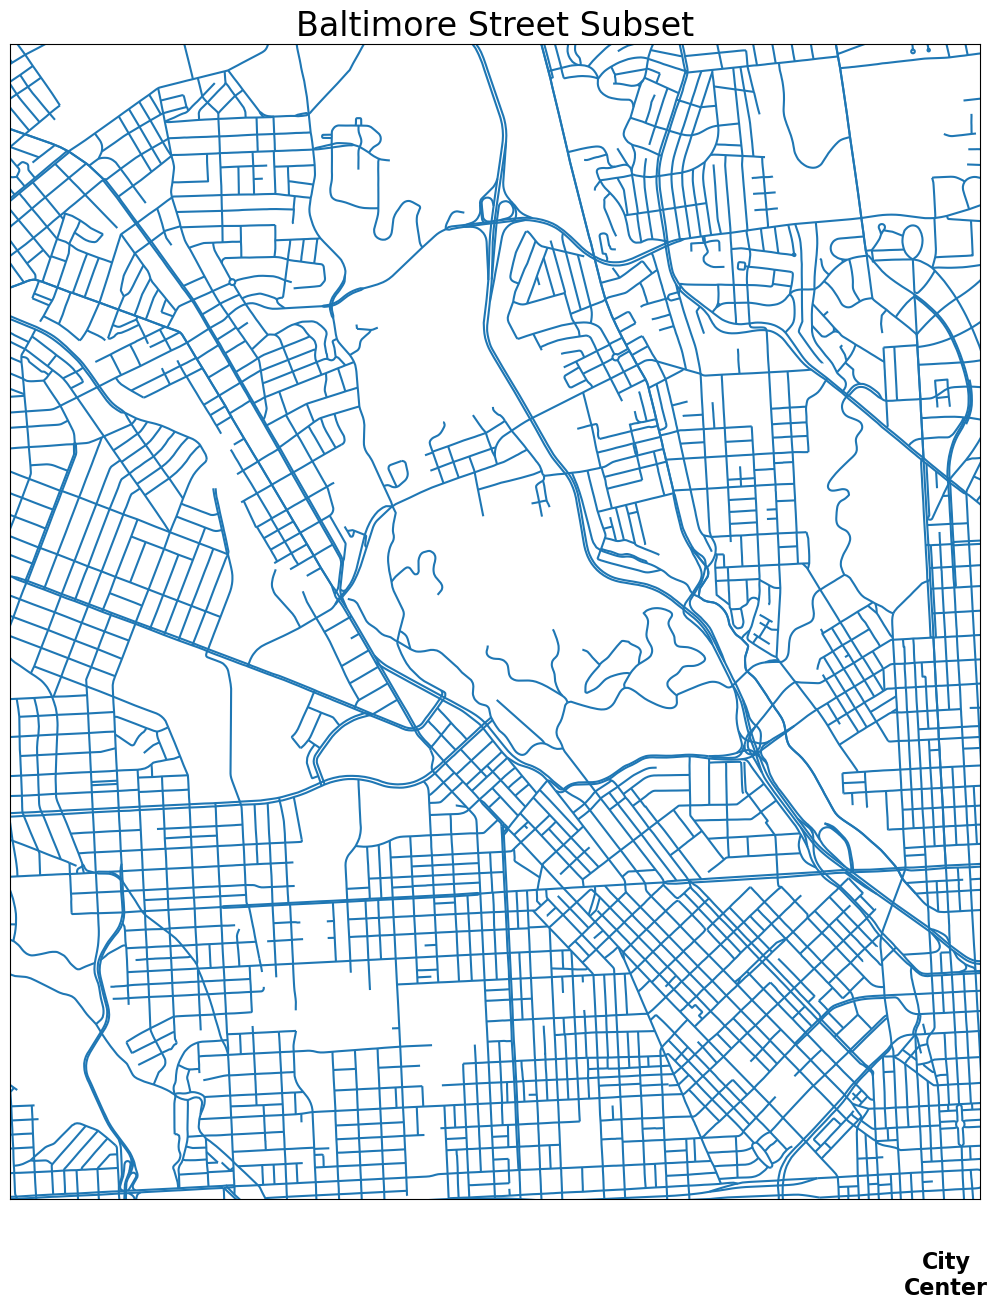

In [13]:
#| code-fold: true
import matplotlib.pyplot as plt
from lib.geo_utils import filter_gdf, make_bounding_box

# Plot the remaining streets
fig, ax = plt.subplots(figsize=(20,15))
baltimore_subset.plot(ax=ax)

# Because longer streets extend past the bounding box, we use the same bounding coordinates
# to limit the borders of the plot. It's confusing if we draw parts of the street segments
# that will be excluded from training
bounding_box = make_bounding_box(minLat=minLat, minLon=minLon, maxLat=maxLat, maxLon=maxLon)
min_x, min_y, max_x, max_y = bounding_box.bounds

# Spherical coordinates for the center of Baltimore
latitude = 39.289444
longitude = -76.616667

center_point = Point(longitude, latitude)
center_point = gpd.GeoSeries(center_point, crs='EPSG:4326')

# Convert center_point to the Maryland State Plane coordinate system
center_point = center_point.to_crs(epsg=26985)
center_point = center_point.centroid

# Plot center_point as a red dot
ax.plot(center_point.x, center_point.y, 'o', color='red')

# write 'Center of Baltimore' below the red dot
ax.text(center_point.x, center_point.y - 100, 'City\nCenter', fontsize=16, ha='center', fontweight='bold')

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

plt.title('Baltimore Street Subset', fontsize=24)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

The central Baltimore subset looks OK, so we proceed to create the network graph, as we did with the sample.

In [14]:
import importlib
import lib.graphs

importlib.reload(lib.graphs)
from lib.graphs import create_network_graph

# Use the row number of each street segment as its ID; the original
# index numbers are not sequential, since we filtered the geodataframe
baltimore_subset.reset_index(inplace=True, drop=True)

G = create_network_graph(baltimore_subset, alpha=750)
print(G)

Graph with 1177 nodes and 3469 edges


In [15]:
for node in list(G.nodes.data())[None:5:None]:
    print(node)

(0, {'NodeID': 367225, 'name': 'N DUKELAND ST', 'position': (429023.8628222718, 181450.00684655222)})
(1, {'NodeID': 367456, 'name': 'W READ ST', 'position': (433112.90626279684, 181374.68178852845)})
(2, {'NodeID': 367483, 'name': 'REMINGTON AVE', 'position': (432440.1964178119, 184064.86845014035)})
(3, {'NodeID': 367488, 'name': 'CANTERBURY RD', 'position': (432716.56154741155, 185417.96152212998)})
(4, {'NodeID': 367592, 'name': 'SWEET AIR ST', 'position': (431223.7876548111, 184620.00943614714)})


## Save the Graph to Disk

Finally, we save the street graph to a JSON file. During model training, the file will be loaded and used to map the locations of crime events.

In [16]:
import pickle
import networkx as nx

path = '../../data/processed/baltimore_street_graph.gpickle'

with open(path, 'wb') as file:
    pickle.dump(G, file)

print(f'Graph saved to {path}')

Graph saved to ../../data/processed/baltimore_street_graph.gpickle


## Save the Streets Geographic Data to Disk

In [17]:
baltimore_subset.to_file('../../data/processed/baltimore_street_segment_subset.json', driver='GeoJSON')

## Up Next {.unnumbered}

In [part 2](../street_graph_feature_engineering/), we perform feature engineering of the temporal dimension: matching each crime events with a node in the street graph for every timestep.